In [1]:
import cv2
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure
import random
import os
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

import pandas as pd
import numpy as np

In [2]:
# Define paths for each fracture type
root = 'data/'
paths = {
    'Hairline Fracture': root + 'Hairline Fracture/Train',
    'Spiral Fracture': root + 'Spiral Fracture/Train',
    'Greenstick Fracture': root + 'Greenstick fracture/Train',
    'Comminuted Fracture': root + 'Comminuted fracture/Train',
    'Fracture Dislocation': root + 'Fracture Dislocation/Train',
    'Pathological Fracture': root + 'Pathological fracture/Train',
    'Longitudinal Fracture': root + 'Longitudinal fracture/Train',
    'Oblique Fracture': root + 'Oblique fracture/Train',
    'Impacted Fracture': root + 'Impacted fracture/Train',
    'Avulsion Fracture': root + 'Avulsion fracture/Train'
}

In [6]:
# Function to get image dimensions
def get_image_dimensions(image_path):
    """
    Get dimensions of an image.

    Args:
    - image_path (str): Path to the image file.

    Returns:
    - tuple: Width and height of the image.
    """
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)
    return image.shape[1], image.shape[0]

# Lists to store image dimensions
widths = []
heights = []

# Loop over each class and its images
for class_name, class_path in paths.items():
    # List all image files in the directory
    image_files = tf.io.gfile.listdir(class_path)
    # Loop over each image file
    for image_file in image_files:
        # Get the full path to the image
        image_path = os.path.join(class_path, image_file)
        # Get the dimensions of the image
        width, height = get_image_dimensions(image_path)
        # Append the dimensions to the lists
        widths.append(width)
        heights.append(height)

# Convert lists to numpy arrays for easier analysis
widths = np.array(widths)
heights = np.array(heights)

# Calculate statistics
min_width = np.min(widths)
max_width = np.max(widths)
mean_width = np.mean(widths)
median_width = np.median(widths)

min_height = np.min(heights)
max_height = np.max(heights)
mean_height = np.mean(heights)
median_height = np.median(heights)

# Print statistics
print(f"Width: min={min_width}, max={max_width}, mean={mean_width}, median={median_width}")
print(f"Height: min={min_height}, max={max_height}, mean={mean_height}, median={median_height}")

Width: min=58, max=640, mean=429.5490394337715, median=443.0
Height: min=77, max=640, mean=561.4509605662286, median=640.0


In [7]:
# Function to load and preprocess an image
def load_image(image_path, image_size=(512, 512)):
    # Read the image from the file
    image = tf.io.read_file(image_path)
    # Decode the JPEG image into a tensor
    image = tf.image.decode_jpeg(image, channels=3)
    # Resize the image to the desired size
    image = tf.image.resize(image, image_size)
    # Normalize the pixel values to [0, 1]
    image = image / 255.0
    return image

def create_2d_gaussian(size, sigma):
    # Create a linear space from -size//2 to size//2
    ax = np.linspace(-(size // 2), size // 2, size)
    # Create a meshgrid from the linear space
    xx, yy = np.meshgrid(ax, ax)
    # Calculate the Gaussian kernel
    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sigma))
    # Normalize the kernel so that the sum is 1
    return kernel / np.sum(kernel)

def convolve2d(image, kernel):
    # Flip the kernel for convolution
    kernel = kernel[::-1, ::-1]
    # Create an output array of the same shape as the input image
    output = np.zeros_like(image)
    # Pad the input image to handle borders
    image_padded = np.pad(image, [(kernel.shape[0]//2, kernel.shape[0]//2), 
                                  (kernel.shape[1]//2, kernel.shape[1]//2)], mode='reflect')
    # Loop over each pixel in the image
    for x in range(image.shape[1]):
        for y in range(image.shape[0]):
            # Perform element-wise multiplication and sum the results
            output[y, x] = (kernel * image_padded[y:y+kernel.shape[0], x:x+kernel.shape[1]]).sum()
    return output

def gaussian_and_laplacian_stack(img, levels, size=17, sigma=3):
    # Initialize the Gaussian stack with the original image
    gaussian_stack = [img]
    # Initialize the Laplacian stack
    laplacian_stack = []

    # Loop to create each level of the Gaussian and Laplacian stacks
    for i in range(1, levels):
        # Create the Gaussian kernel
        gaussian_kernel = create_2d_gaussian(size, sigma)
        # Convolve the last image in the Gaussian stack with the Gaussian kernel
        gaussian = convolve2d(gaussian_stack[-1], gaussian_kernel)
        # Append the resulting image to the Gaussian stack
        gaussian_stack.append(gaussian)
        # Calculate the Laplacian image by subtracting the current Gaussian image from the previous one
        laplacian = gaussian_stack[-2] - gaussian
        # Append the Laplacian image to the Laplacian stack
        laplacian_stack.append(laplacian)

    # The last level of the Laplacian stack is the last image in the Gaussian stack
    laplacian_stack.append(gaussian_stack[-1])
    return gaussian_stack, laplacian_stack

def visualize_stack(in_stack, title):
    # Create a figure with subplots for each level in the stack
    fig, axes = plt.subplots(1, len(in_stack), figsize=(15, 10))
    # Loop over each level and corresponding subplot axis
    for i, (ax, img) in enumerate(zip(axes, in_stack)):
        # Display the image on the axis
        ax.imshow(img, cmap='gray', vmin=np.min(img), vmax=np.max(img))
        # Set the title of the subplot to indicate the level
        ax.set_title(f'Level {i+1}')
        # Remove the axis ticks and labels
        ax.axis('off')
    # Set the overall title for the figure
    fig.suptitle(title)
    # Show the figure
    plt.show()

# Custom feature extraction functions
def extract_hog_features(image):
    # Convert the image to uint8 format and scale pixel values to [0, 255]
    image = (image * 255).numpy().astype('uint8')
    # Extract HOG features and the HOG image
    fd, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2), visualize=True, channel_axis=-1)
    return fd, hog_image

def extract_canny_edges(image):
    # Convert the image to uint8 format and scale pixel values to [0, 255]
    image = (image * 255).numpy().astype('uint8')
    # Extract Canny edges
    edges = cv2.Canny(image, threshold1=100, threshold2=200)
    return edges.ravel(), edges

def extract_contours(image):
    # Convert the image to uint8 format and scale pixel values to [0, 255]
    image = (image * 255).numpy().astype('uint8')
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Apply a binary threshold to the grayscale image
    ret, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    # Find contours in the binary image
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # Initialize a list to store contour features
    contour_features = []
    # Loop over the first 5 contours
    for contour in contours[:5]:
        # Calculate the moments of the contour
        moments = cv2.moments(contour)
        # Calculate the Hu moments and flatten them
        hu_moments = cv2.HuMoments(moments).flatten()
        # Append the Hu moments to the contour features list
        contour_features.extend(hu_moments)
    return np.array(contour_features), contours

In [8]:
# Print label to fracture mapping
label_to_fracture = {label: fracture for label, fracture in enumerate(paths.keys())}
print("Label to Fracture Mapping:")
for label, fracture in label_to_fracture.items():
    print(f"{label}: {fracture}")

Label to Fracture Mapping:
0: Hairline Fracture
1: Spiral Fracture
2: Greenstick Fracture
3: Comminuted Fracture
4: Fracture Dislocation
5: Pathological Fracture
6: Longitudinal Fracture
7: Oblique Fracture
8: Impacted Fracture
9: Avulsion Fracture


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


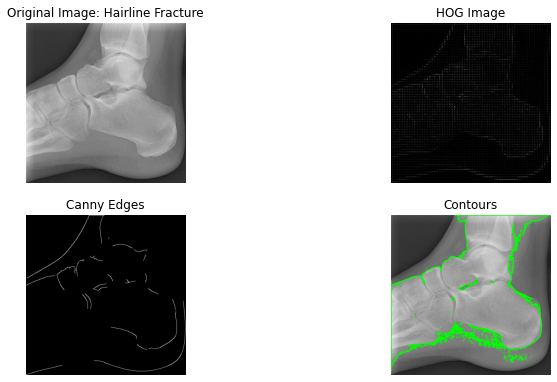

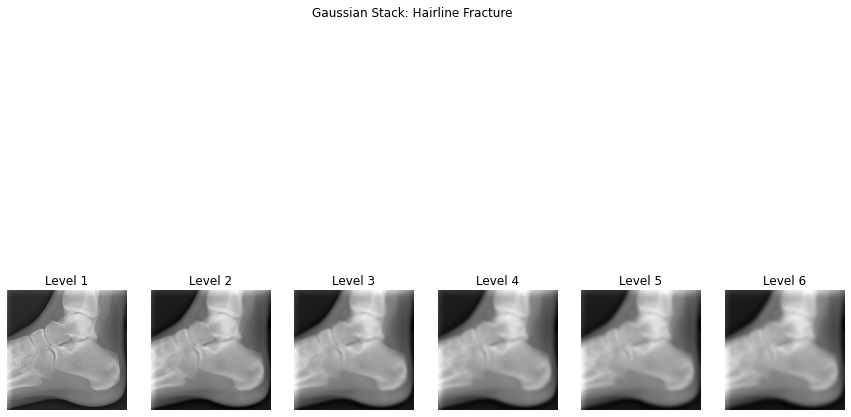

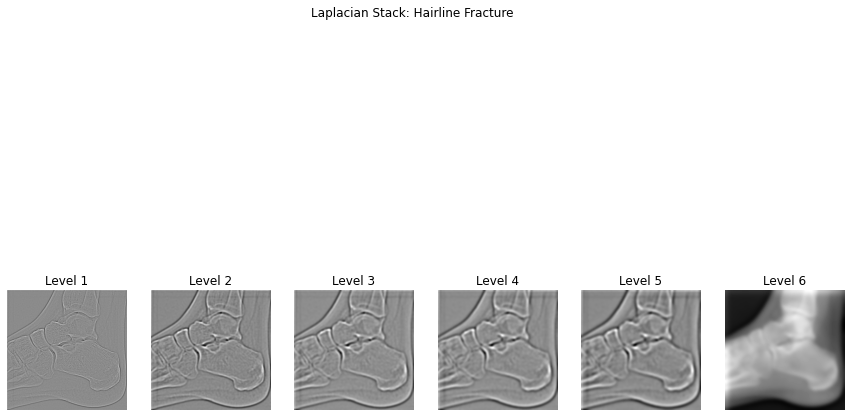

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


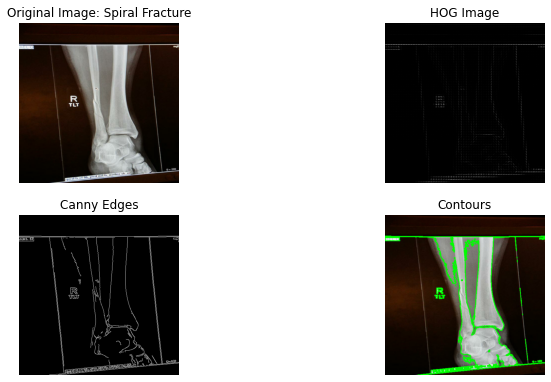

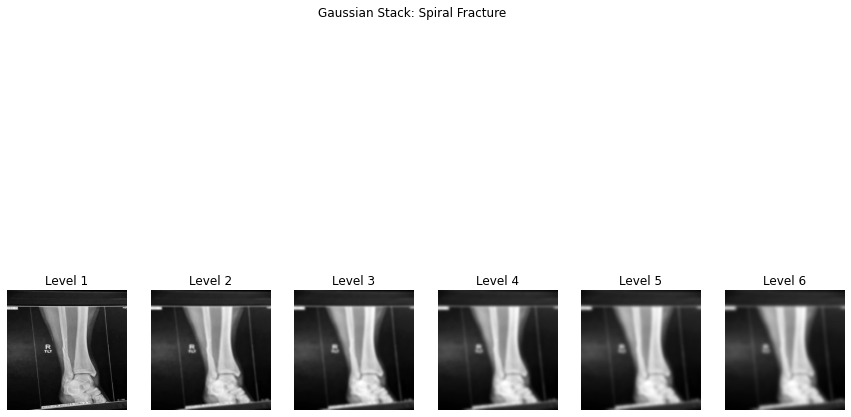

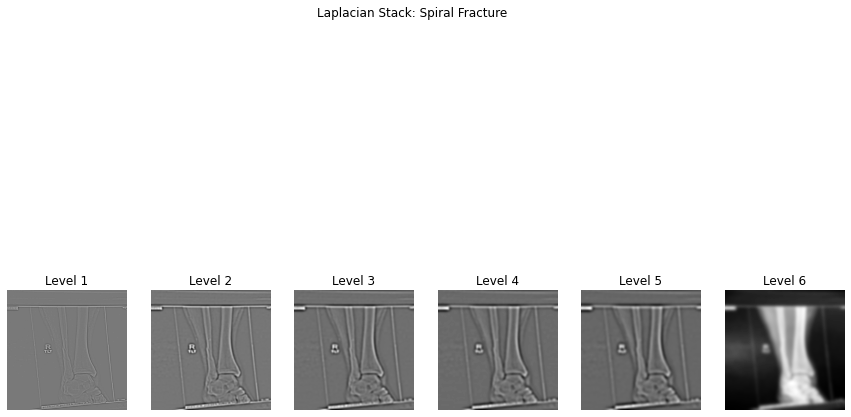

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


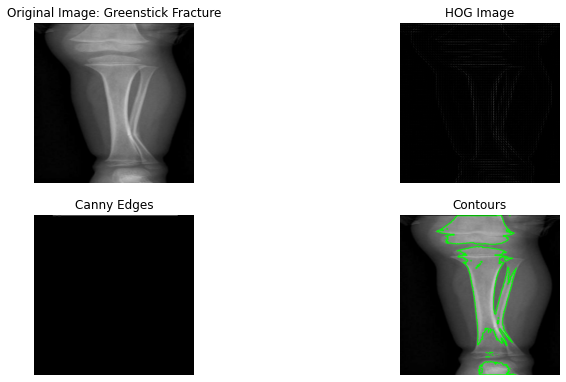

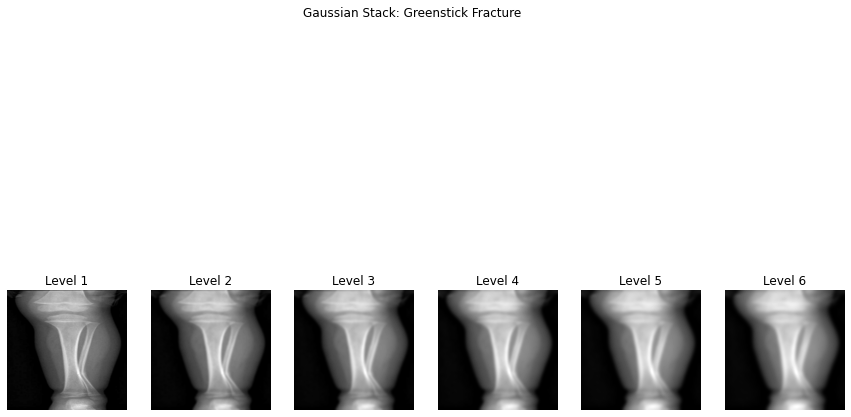

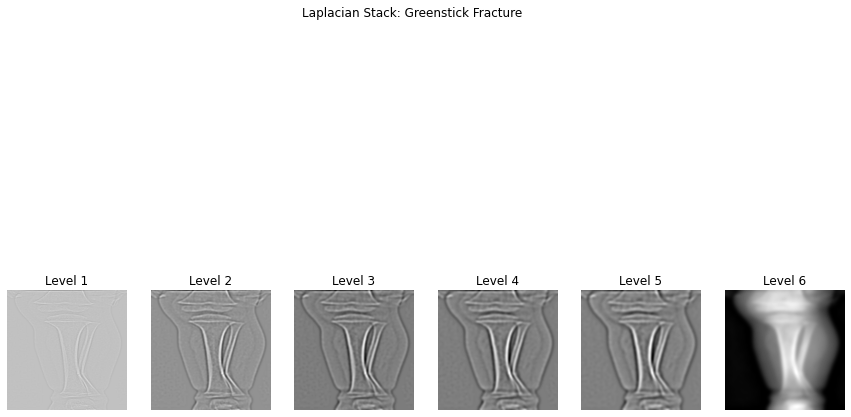

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


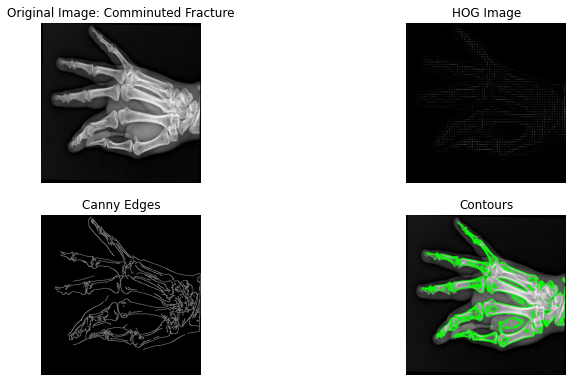

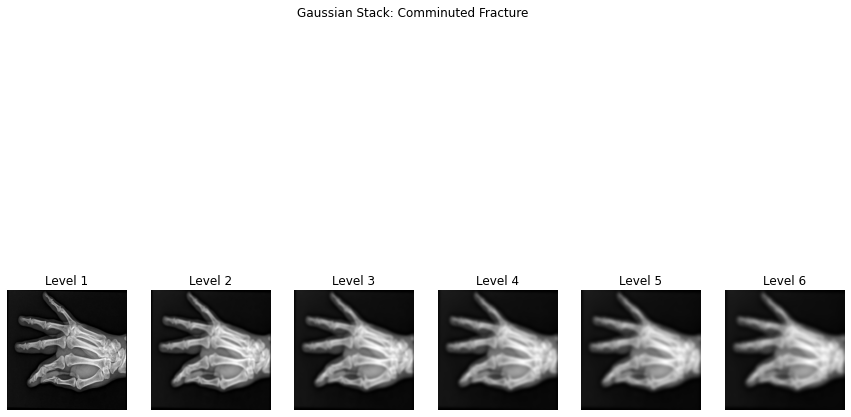

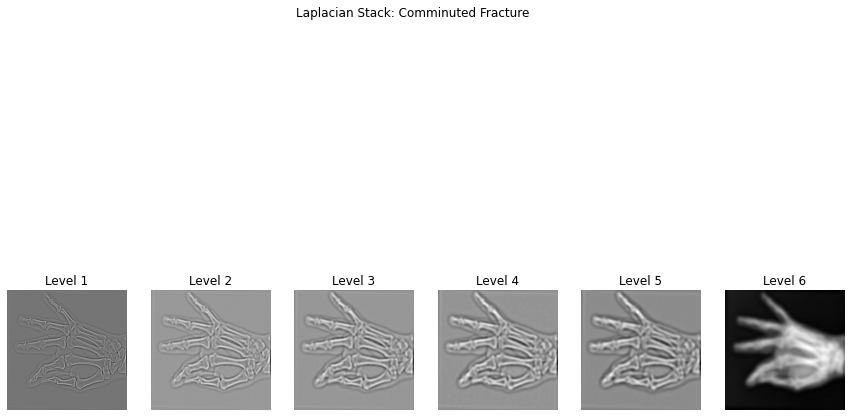

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


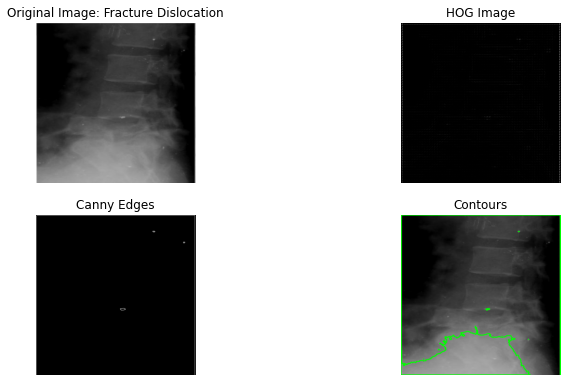

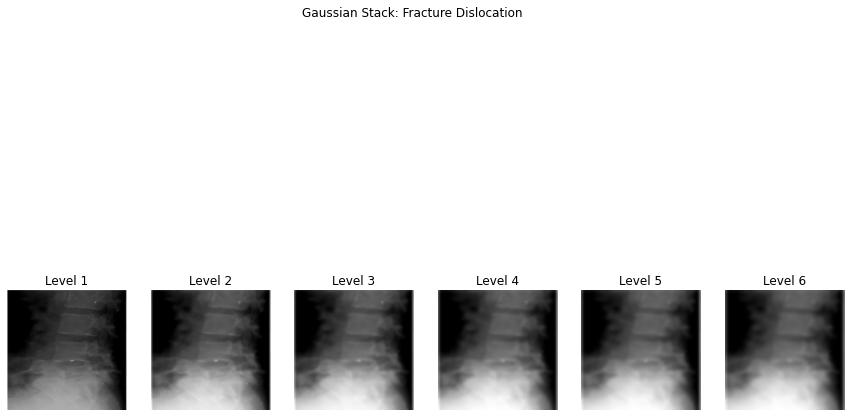

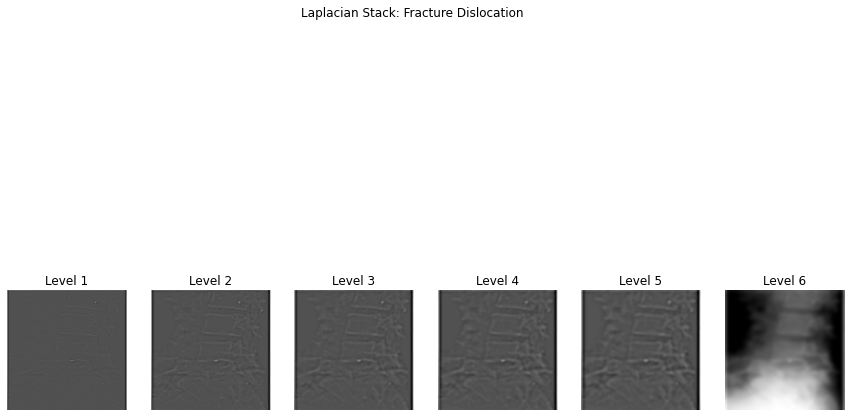

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


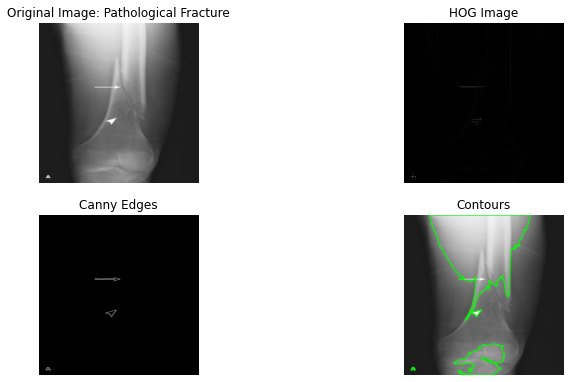

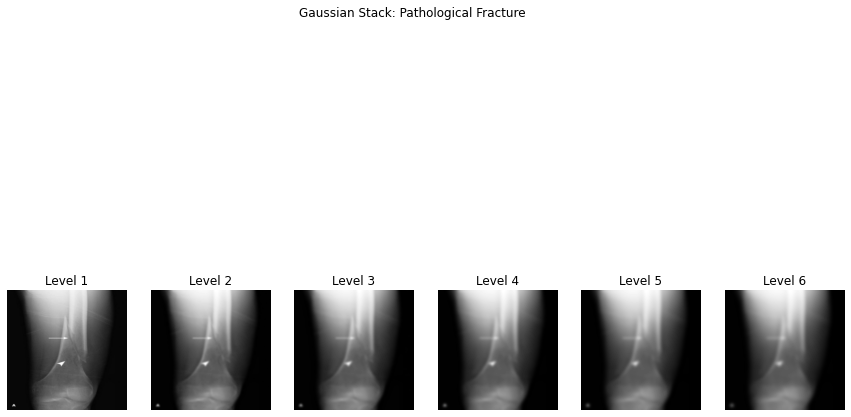

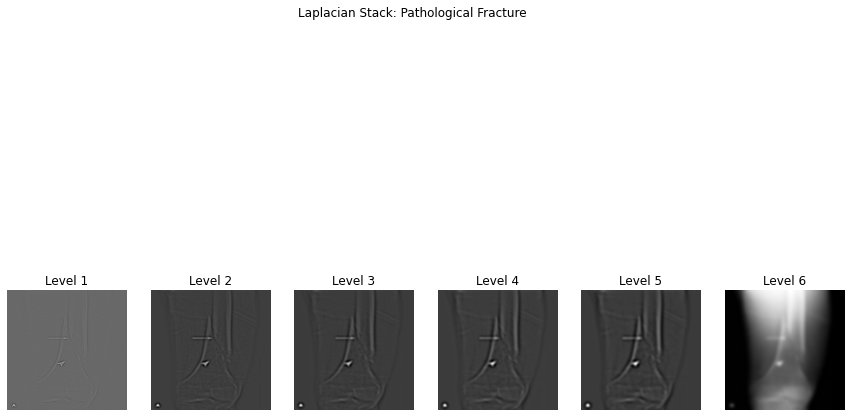

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


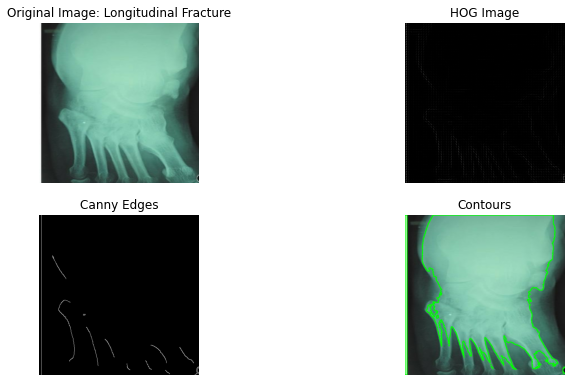

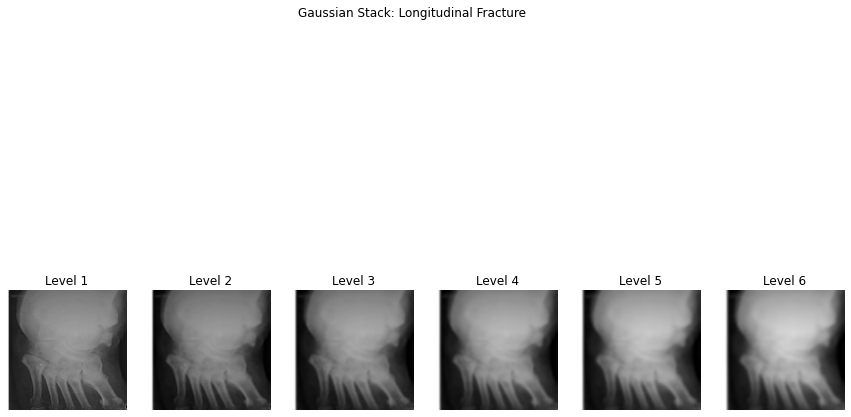

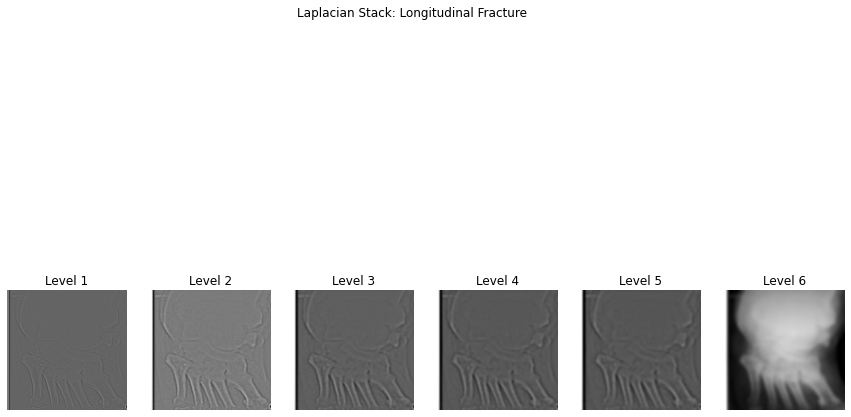

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


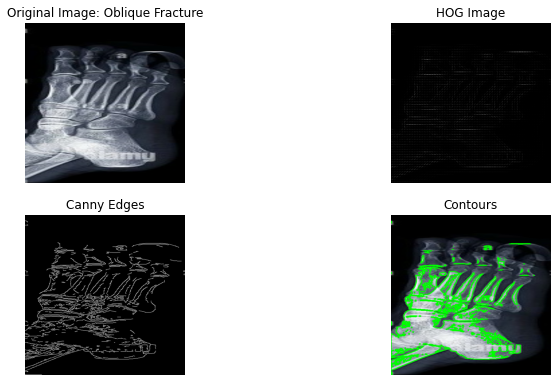

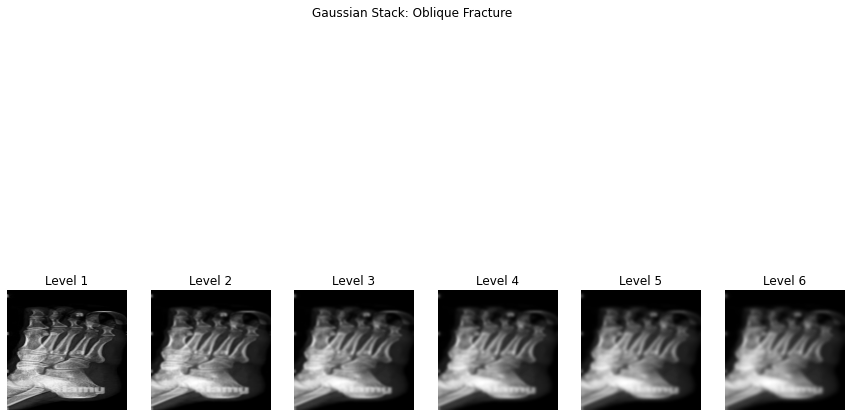

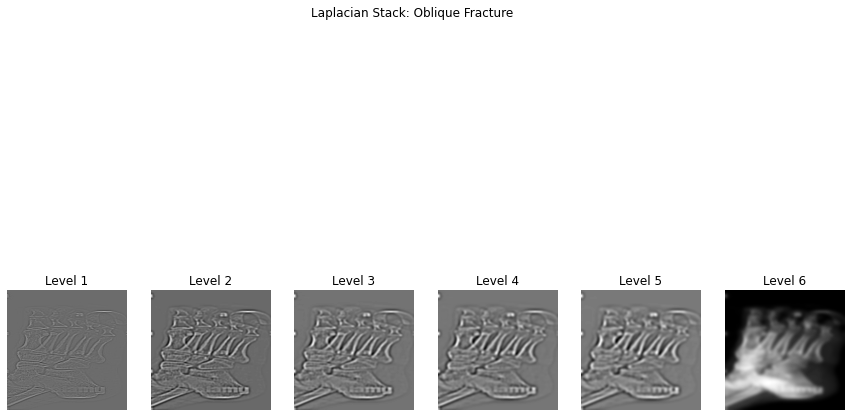

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


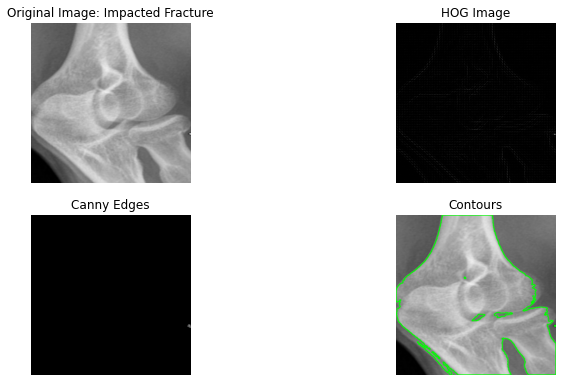

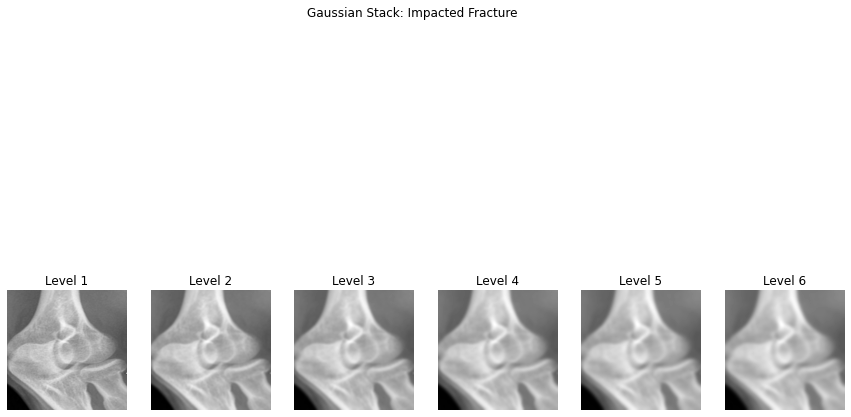

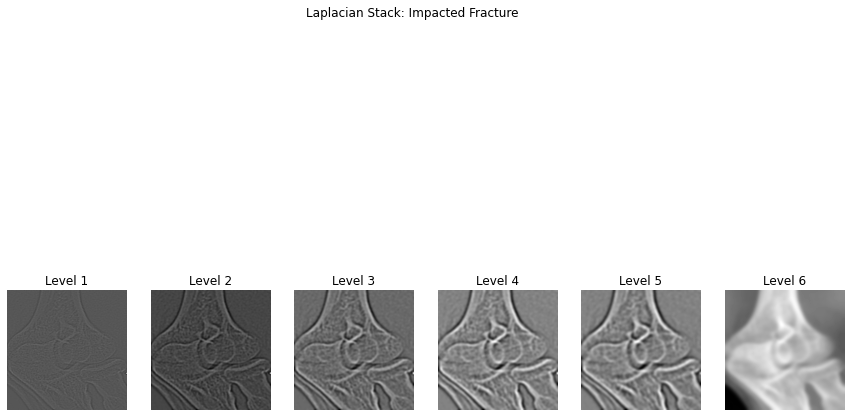

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


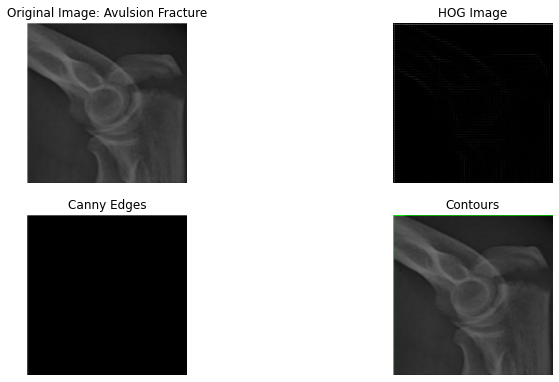

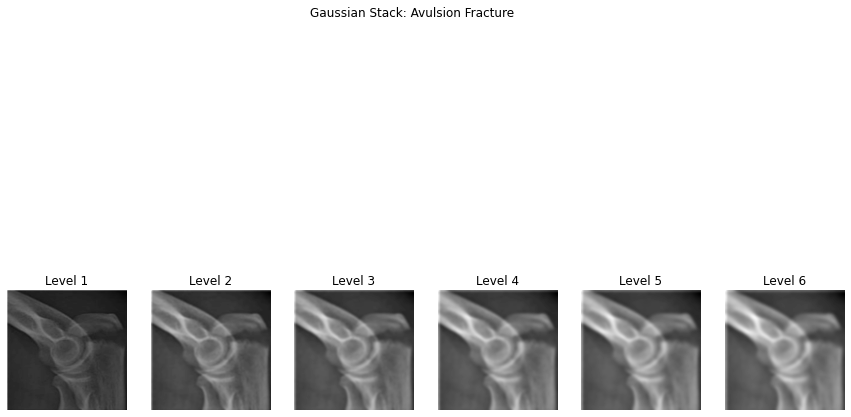

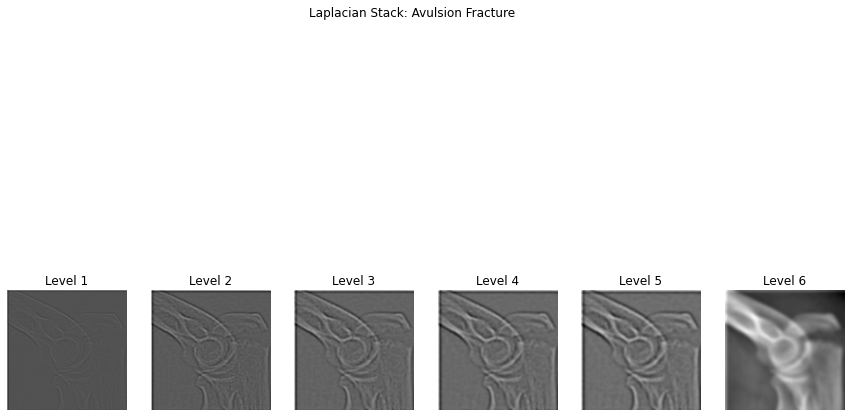

In [9]:
# Function to visualize features
def visualize_features(image_path, class_name):
    # Load and preprocess the image
    image = load_image(image_path)
    # Convert the image tensor to a numpy array
    image_np = image.numpy()

    # Extract features using the defined functions
    hog_features, hog_image = extract_hog_features(image)
    canny_features, canny_image = extract_canny_edges(image)
    contour_features, contours = extract_contours(image)
    # Create Gaussian and Laplacian stacks for the image
    gaussian_stack, laplacian_stack = gaussian_and_laplacian_stack(image_np[:, :, 0], levels=6)

    # Plot the original image and the extracted features
    plt.figure(figsize=(12, 10))

    plt.subplot(3, 2, 1)
    plt.title(f'Original Image: {class_name}')
    plt.imshow(image_np)
    plt.axis('off')

    plt.subplot(3, 2, 2)
    plt.title('HOG Image')
    plt.imshow(hog_image, cmap='gray')
    plt.axis('off')

    plt.subplot(3, 2, 3)
    plt.title('Canny Edges')
    plt.imshow(canny_image, cmap='gray')
    plt.axis('off')

    plt.subplot(3, 2, 4)
    plt.title('Contours')
    plt.imshow(cv2.drawContours(image_np.copy(), contours, -1, (0, 255, 0), 2))
    plt.axis('off')

    # Visualize the Gaussian and Laplacian stacks
    visualize_stack(gaussian_stack, title=f'Gaussian Stack: {class_name}')
    visualize_stack(laplacian_stack, title=f'Laplacian Stack: {class_name}')

# Visualize features for an image in each class
for class_name, class_path in paths.items():
    # List all image files in the directory
    image_files = tf.io.gfile.listdir(class_path)
    # If there are any images in the directory
    if image_files:
        # Get the path to the first image
        first_image_path = os.path.join(class_path, image_files[0])
        # Visualize the features for the first image
        visualize_features(first_image_path, class_name)